In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64, 128), latentDim=16):
        # inicializar la entrada de la red
        inputShape = (height, width, depth)
        chanDim = -1
        # Definir la entrada
        inputs = Input(shape=inputShape)
        x = inputs
        # Bucle que crea los filtros de cada capa
        for f in filters:
            
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
       # crear el modelo de encoder
        encoder = Model(inputs, latent, name="encoder")
        
        # crear el modelo de salida
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        # Bucle para crear el decoder
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # Aplicar transpose para reponer la imagen
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        # Crear decoder
        decoder = Model(latentInputs, outputs, name="decoder")
        
        # Crear el modelo completto
        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")
        
        return (encoder, decoder, autoencoder)

In [2]:
import os 
import cv2
import numpy as np
import tensorflow as tf  
import matplotlib.pyplot as plt

## Colocar la direccion de la carpeta de iamgenes originales
path_o= '/home/fer/MATLAB_1/DenoisingNetwork/train/original'
path_n= '/home/fer/MATLAB_1/DenoisingNetwork/train/noisy'
path_r = '/home/fer/MATLAB_1/DenoisingNetwork/restauradas/'

def main():                                                                                                             
    print('Hola Luis Fernando')                                                                                         
                                                                                                                        
def data(path):
    training_data = []
    index = os.listdir(path)
    index.sort()
    index =index[0:1]
    for img in index:
        pic_o = cv2.imread(os.path.join(path,img),0)
        pic_o = cv2.resize(pic_o,(688,688))
        training_data.append([pic_o])
    training = np.array(training_data).reshape(len(training_data),pic_o.shape[0],pic_o.shape[1])
    return training

def normalization(train, test):
    ## Normalizacion de los valores se colocan entre 0-1
    train_n = train.astype('float32')/255
    test_n = test.astype('float32')/255
    train_n = train_n[...,tf.newaxis]
    test_n = test_n[...,tf.newaxis]
    return train_n, test_n

def plot_noisy(original, noisy):
    plt.figure(figsize=(20,8))
    plt.gray()
    n =original.shape[0]
    for i in range(n):
        ax = plt.subplot(2, n , i+1)
        plt.title("Original",size=20)
        plt.imshow(tf.squeeze(original[i]))
        plt.gray()
        bx = plt.subplot(2, n, n+ i +1) 
        plt.title("original + noise", size=20) 
        plt.imshow(tf.squeeze(noisy[i])) 
    plt.show()
    
def show_one(x_test,i):
    ## Funcion para verificar solo una Imagen
    fig, axs = plt.subplots(1, 1)  
    fig.tight_layout(pad=-1)                                                                                            
    plt.gray()  
    axs.imshow(tf.squeeze(x_test[i]))  

(1, 688, 688, 1)


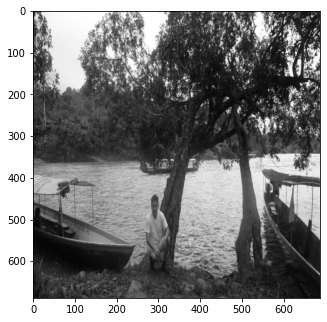

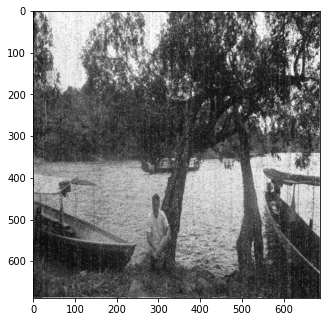

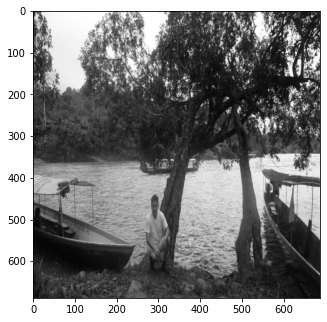

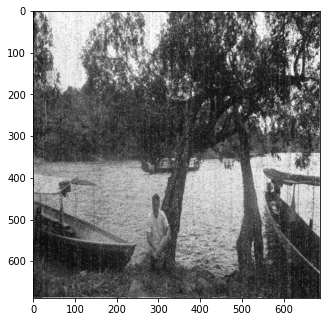

In [3]:
import matplotlib.pyplot as plt
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

def vizualize_image(img):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Imagen", fontsize=10)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    return None
    
def show_figure(img):
    n=img.shape[0]
    fig, axs =plt.subplots(1,n)
    plt.gray()
    a = 0
    for k in range(n):
        axs[k].imshow(img[a])
        a = a+1
    plt.show()

# construct the argument parse and parse the arguments

# initialize the number of epochs to train for and batch size
EPOCHS = 800


# Cargar las imagenes respectivas
trainX = data(path_o)
testX =  data(path_o)
# add a channel dimension to every image in the dataset, then scale

# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0     

## Verificacion de la dimension de las imagenes que se lee
print(trainX.shape)

## Agregar ruido a las iamgenes
trainXNoisy = data(path_n)
testXNoisy = data(path_n)

trainXNoisy = np.expand_dims(trainXNoisy, axis=-1)
testXNoisy = np.expand_dims(testXNoisy, axis=-1)
trainXNoisy = trainXNoisy.astype("float32") / 255.0
testXNoisy = testXNoisy.astype("float32") / 255.0   

## visualizar las imgenes con ruido
show_one(trainX, 0)
show_one(trainXNoisy, 0)
show_one(testX, 0)
show_one(testXNoisy, 0)


In [4]:
## generacion del autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(trainX.shape[1], trainX.shape[2], 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer='adam')
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
    shuffle=True)

Epoch 1/800
1/1 [==============================] - 2s 2s/step - loss: 0.1535 - val_loss: 0.0852
Epoch 2/800
1/1 [==============================] - 1s 1s/step - loss: 0.1726 - val_loss: 0.0847
Epoch 3/800
1/1 [==============================] - 1s 1s/step - loss: 0.0984 - val_loss: 0.0840
Epoch 4/800
1/1 [==============================] - 1s 1s/step - loss: 0.0707 - val_loss: 0.0832
Epoch 5/800
1/1 [==============================] - 1s 1s/step - loss: 0.0497 - val_loss: 0.0821
Epoch 6/800
1/1 [==============================] - 1s 1s/step - loss: 0.0328 - val_loss: 0.0806
Epoch 7/800
1/1 [==============================] - 1s 1s/step - loss: 0.0234 - val_loss: 0.0790
Epoch 8/800
1/1 [==============================] - 1s 1s/step - loss: 0.0198 - val_loss: 0.0774
Epoch 9/800
1/1 [==============================] - 1s 1s/step - loss: 0.0175 - val_loss: 0.0761
Epoch 10/800
1/1 [==============================] - 1s 1s/step - loss: 0.0154 - val_loss: 0.0751
Epoch 11/800
1/1 [=====================

Epoch 166/800
1/1 [==============================] - 1s 1s/step - loss: 3.3872e-04 - val_loss: 0.0510
Epoch 167/800
1/1 [==============================] - 1s 1s/step - loss: 3.3431e-04 - val_loss: 0.0509
Epoch 168/800
1/1 [==============================] - 1s 1s/step - loss: 3.2998e-04 - val_loss: 0.0508
Epoch 169/800
1/1 [==============================] - 1s 1s/step - loss: 3.2572e-04 - val_loss: 0.0506
Epoch 170/800
1/1 [==============================] - 1s 1s/step - loss: 3.2154e-04 - val_loss: 0.0505
Epoch 171/800
1/1 [==============================] - 1s 1s/step - loss: 3.1743e-04 - val_loss: 0.0504
Epoch 172/800
1/1 [==============================] - 1s 1s/step - loss: 3.1339e-04 - val_loss: 0.0502
Epoch 173/800
1/1 [==============================] - 1s 1s/step - loss: 3.0940e-04 - val_loss: 0.0501
Epoch 174/800
1/1 [==============================] - 1s 1s/step - loss: 3.0547e-04 - val_loss: 0.0500
Epoch 175/800
1/1 [==============================] - 1s 1s/step - loss: 3.0159e-04

1/1 [==============================] - 1s 1s/step - loss: 9.6000e-05 - val_loss: 0.0280
Epoch 327/800
1/1 [==============================] - 1s 1s/step - loss: 9.5522e-05 - val_loss: 0.0279
Epoch 328/800
1/1 [==============================] - 1s 1s/step - loss: 9.5048e-05 - val_loss: 0.0277
Epoch 329/800
1/1 [==============================] - 1s 1s/step - loss: 9.4578e-05 - val_loss: 0.0276
Epoch 330/800
1/1 [==============================] - 1s 1s/step - loss: 9.4114e-05 - val_loss: 0.0274
Epoch 331/800
1/1 [==============================] - 1s 1s/step - loss: 9.3652e-05 - val_loss: 0.0273
Epoch 332/800
1/1 [==============================] - 1s 1s/step - loss: 9.3195e-05 - val_loss: 0.0272
Epoch 333/800
1/1 [==============================] - 1s 1s/step - loss: 9.2742e-05 - val_loss: 0.0270
Epoch 334/800
1/1 [==============================] - 1s 1s/step - loss: 9.2292e-05 - val_loss: 0.0269
Epoch 335/800
1/1 [==============================] - 1s 1s/step - loss: 9.1846e-05 - val_loss: 0

1/1 [==============================] - 1s 1s/step - loss: 4.5450e-05 - val_loss: 0.0106
Epoch 487/800
1/1 [==============================] - 1s 1s/step - loss: 4.5241e-05 - val_loss: 0.0105
Epoch 488/800
1/1 [==============================] - 1s 1s/step - loss: 4.5031e-05 - val_loss: 0.0105
Epoch 489/800
1/1 [==============================] - 1s 1s/step - loss: 4.4822e-05 - val_loss: 0.0104
Epoch 490/800
1/1 [==============================] - 1s 1s/step - loss: 4.4614e-05 - val_loss: 0.0103
Epoch 491/800
1/1 [==============================] - 1s 1s/step - loss: 4.4406e-05 - val_loss: 0.0103
Epoch 492/800
1/1 [==============================] - 1s 1s/step - loss: 4.4198e-05 - val_loss: 0.0102
Epoch 493/800
1/1 [==============================] - 1s 1s/step - loss: 4.3991e-05 - val_loss: 0.0101
Epoch 494/800
1/1 [==============================] - 1s 1s/step - loss: 4.3785e-05 - val_loss: 0.0100
Epoch 495/800
1/1 [==============================] - 1s 1s/step - loss: 4.3580e-05 - val_loss: 0

1/1 [==============================] - 1s 1s/step - loss: 2.0512e-05 - val_loss: 0.0037
Epoch 647/800
1/1 [==============================] - 1s 1s/step - loss: 2.0423e-05 - val_loss: 0.0037
Epoch 648/800
1/1 [==============================] - 1s 1s/step - loss: 2.0335e-05 - val_loss: 0.0036
Epoch 649/800
1/1 [==============================] - 1s 1s/step - loss: 2.0247e-05 - val_loss: 0.0036
Epoch 650/800
1/1 [==============================] - 1s 1s/step - loss: 2.0159e-05 - val_loss: 0.0036
Epoch 651/800
1/1 [==============================] - 1s 1s/step - loss: 2.0072e-05 - val_loss: 0.0036
Epoch 652/800
1/1 [==============================] - 1s 1s/step - loss: 1.9985e-05 - val_loss: 0.0036
Epoch 653/800
1/1 [==============================] - 1s 1s/step - loss: 1.9898e-05 - val_loss: 0.0036
Epoch 654/800
1/1 [==============================] - 1s 1s/step - loss: 1.9812e-05 - val_loss: 0.0036
Epoch 655/800
1/1 [==============================] - 1s 1s/step - loss: 1.9726e-05 - val_loss: 0

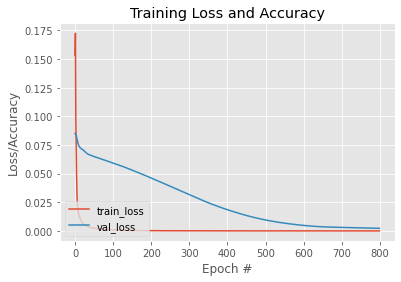

In [6]:
decoded = autoencoder.predict(testXNoisy)

In [7]:
decoded.shape

(1, 688, 688, 1)

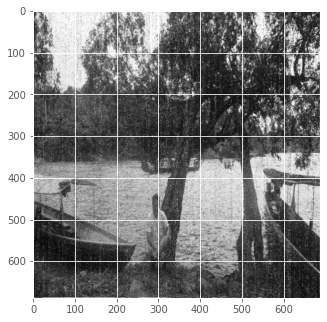

In [8]:
show_one(testXNoisy,0)

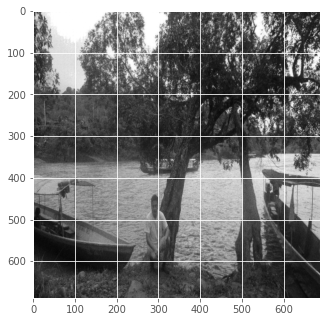

In [9]:
show_one(decoded,0)

In [13]:
## convertir de tensor a una numpy
norm_image = cv2.normalize(decoded, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

## convertir al tipo de dato inicial
norm_image = norm_image.astype(np.uint8)

In [14]:
cv2.imwrite(os.path.join(path_r , 'reutarada.jpg'), norm_image[0,:,:,0])

True